<a href="https://colab.research.google.com/github/juliakahan/MountainCarContinuous-with-PPO/blob/main/Mountain_Car_Continuous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Learning Notes of Renee. Article:

In [1]:
pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 35.4 MB/s eta 0:00:00


In [2]:
!pip install "stable-baselines3[extra]>=2.0.0a4"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.2/178.2 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 40.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.4 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=dc0c520d8ae6b4c6e67940d4c8102c2a62c5cbd3248f0de0d85d66f5be15a997
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [3]:
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
import gymnasium as gym
import os
import time
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


In [4]:
# Saving logs to visulise in Tensorboard, saving models
models_dir = f"models/Mountain-{time.time()}"
logdir = f"logs/Mountain-{time.time()}"

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(logdir):
    os.makedirs(logdir)

In [5]:
# Parallel environments
env = make_vec_env("MountainCarContinuous-v0", n_envs=1)

In [7]:
# Define multiple sets of hyperparameters
hyperparams = [
    {"ent_coef": 0.001, "learning_rate": 0.0001, "n_epochs": 10},
    {"ent_coef": 0.005, "learning_rate": 0.0005, "n_epochs": 20},
    {"ent_coef": 0.01, "learning_rate": 0.001, "n_epochs": 30}
]
results = []

In [12]:
for hyperparam in hyperparams:
    model = PPO(
        policy=MlpPolicy,
        env=env,
        seed=0,
        batch_size=256,
        ent_coef=hyperparam["ent_coef"],
        learning_rate=hyperparam["learning_rate"],
        n_epochs=hyperparam["n_epochs"],
        n_steps=8,
        gae_lambda=0.9,
        gamma=0.9999,
        clip_range=0.1,
        max_grad_norm=5,
        vf_coef=0.19,
        use_sde=True,
        policy_kwargs=dict(log_std_init=-3.29, ortho_init=False),
        verbose=1,
        tensorboard_log=logdir
    )

    rewards_per_run = []

    TIMESTEPS = 1000
    for _ in range(10):
        model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False, tb_log_name="PPO")
        ep_info = model.ep_info_buffer
        mean_reward = np.mean([info['r'] for info in ep_info])
        rewards_per_run.append(mean_reward)

    results.append({
        "hyperparams": hyperparam,
        "mean_reward": np.mean(rewards_per_run),
        "std_reward": np.std(rewards_per_run)
    })

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
|    fps                  | 89           |
|    iterations           | 23           |
|    time_elapsed         | 2            |
|    total_timesteps      | 8184         |
| train/                  |              |
|    approx_kl            | 0.0011063442 |
|    clip_fraction        | 0.679        |
|    clip_range           | 0.1          |
|    entropy_loss         | 2.52         |
|    explained_variance   | -1.19e-07    |
|    learning_rate        | 0.001        |
|    loss                 | -0.000105    |
|    n_updates            | 30660        |
|    policy_gradient_loss | 0.0196       |
|    std                  | 0.00661      |
|    value_loss           | 0.0337       |
------------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 999        |
|    ep_rew_mean          | -85.8      |
| time/                   |            |

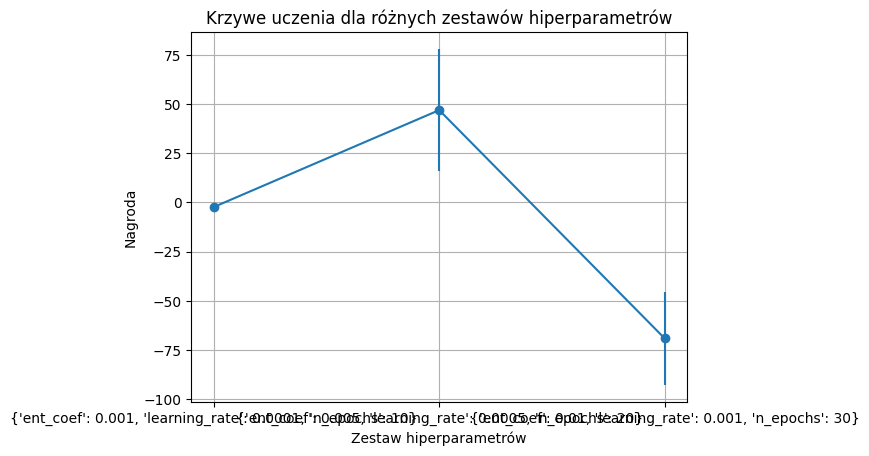

In [13]:
# Plotting the learning curves
x = range(1, len(hyperparams) + 1)
y_mean = [result["mean_reward"] for result in results]
y_std = [result["std_reward"] for result in results]

plt.errorbar(x, y_mean, y_std, linestyle="-", marker="o")
plt.xlabel("Zestaw hiperparametrów")
plt.ylabel("Nagroda")
plt.xticks(x, [str(hyperparam) for hyperparam in hyperparams])
plt.title("Krzywe uczenia dla różnych zestawów hiperparametrów")
plt.grid(True)
plt.show()